In [17]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1. LOAD

In [19]:
df = pd.read_csv("C:/Users/User/Desktop/Nairobi House Price Prediction/data/clean_listings.csv")

In [20]:
df.head(5)

,location,property_type,bedrooms,bathrooms,size_sqft,amenities,price_kes,listing_date,price_per_sqft,amenity_score,month
0,Westlands,Apartment,1,1,699.66,Parking (1),6500000,2026-02-18,9290.226682,1,2
1,Westlands,Apartment,3,3,1668.42,Parking (3),21714000,2026-02-18,13014.708527,1,2
2,Westlands,Apartment,4,5,2271.20,Parking (3),27500000,2026-02-18,12108.136668,1,2
3,Kilimani,Apartment,2,2,1291.68,Parking (1),14800000,2026-02-18,11457.946241,1,2
4,Kilimani,Apartment,2,2,1130.22,Parking (1),9700000,2026-02-18,8582.399887,1,2


## 2. FEATURE ENGINEERING (EXTRACTING VALUE)

In [21]:
# Instead of a generic score, let's extract specific value-drivers
df['has_garden'] = df['amenities'].str.contains('Garden', na=False).astype(int)
df['parking_spaces'] = df['amenities'].str.extract(r'Parking \((\d+)\)').fillna(0).astype(int)

## 3. PREPARING DATA (ONE-HOT ENCODING)

In [22]:
# We use get_dummies for Location and Property Type
categorical_cols = ['location', 'property_type']
numeric_cols = ['bedrooms', 'bathrooms', 'size_sqft', 'parking_spaces', 'has_garden']
X = pd.get_dummies(df[numeric_cols + categorical_cols], drop_first=True)

In [23]:
# TARGET TRANSFORMATION: Log price to handle the huge range (4M to 350M)
y = np.log1p(df['price_kes'])

## 4. TRAIN/TEST SPLIT

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 213 samples
Test set: 54 samples


## 5. MODEL TRAINING

In [25]:
model = LinearRegression()
model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [28]:
print("\n Model trained successfully!")
print(f"   Trained on {len(X_train)} samples")


 Model trained successfully!
   Trained on 213 samples


## 6. PREDICTIONS (Convert back from Log to KES)

In [29]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

In [36]:
# Take first 10 rows of comparison
top10_comparison = comparison.head(10)

# Format numbers as KES with commas
top10_comparison_formatted = top10_comparison.copy()
for col in top10_comparison_formatted.columns:
    top10_comparison_formatted[col] = top10_comparison_formatted[col].apply(lambda x: f"KES {x:,.0f}")

# Print table with index removed
print("\nTop 10 Predictions vs Actual Prices:")
print(top10_comparison_formatted.to_string(index=False))



Top 10 Predictions vs Actual Prices:
  Actual (KES) Predicted (KES) Difference (KES) Absolute Error (KES)
KES 12,600,000  KES 12,623,343      KES -23,343           KES 23,343
 KES 7,150,000  KES 12,078,554   KES -4,928,554        KES 4,928,554
 KES 8,400,000   KES 8,269,635      KES 130,365          KES 130,365
KES 21,000,000  KES 20,542,051      KES 457,949          KES 457,949
KES 12,840,000  KES 12,751,120       KES 88,880           KES 88,880


## 7. PERFORMANCE SUMMARY

In [37]:
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"--- BASELINE MODEL PERFORMANCE ---")
print(f"MAE: {mae:,.2f} KES")
print(f"R2 Score: {r2:.4f}")
print(f"Interpretation: On average, predictions are off by {mae/1e6:.2f}M KES.")

--- BASELINE MODEL PERFORMANCE ---
MAE: 8,035,678.91 KES
R2 Score: 0.6235
Interpretation: On average, predictions are off by 8.04M KES.


## 8. VISUALIZATION

### ACTUAL VS PREDICTED

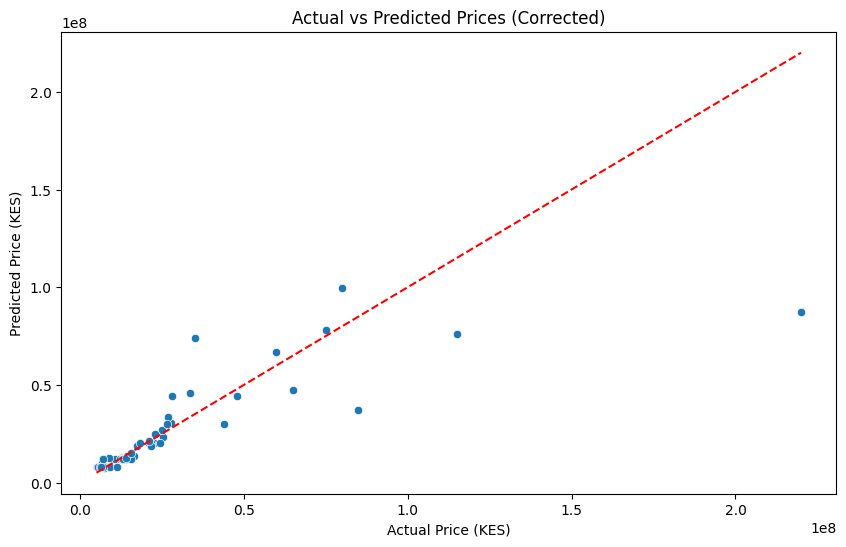

In [38]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_actual, y=y_pred)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.title('Actual vs Predicted Prices (Corrected)')
plt.xlabel('Actual Price (KES)')
plt.ylabel('Predicted Price (KES)')
plt.show()

### Top 10 Positive Price Drivers

C:\Users\User\AppData\Local\Temp\ipykernel_23252\370403236.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.values, y=top_10.index, palette='magma')


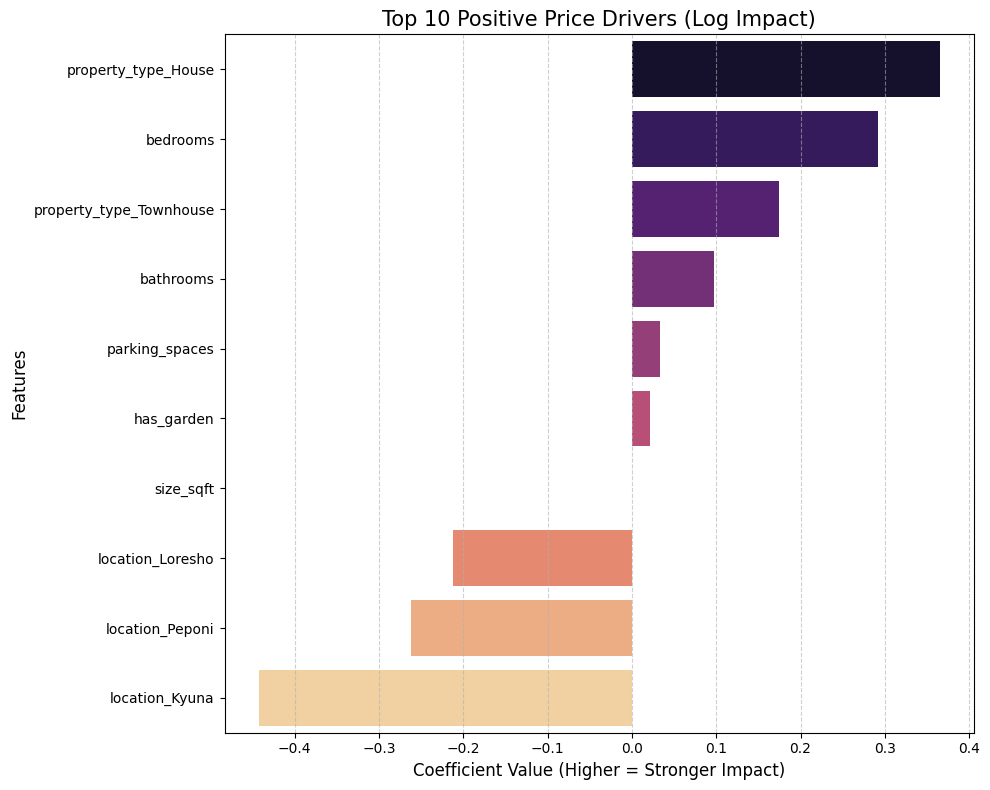

In [39]:
plt.figure(figsize=(10, 8))
importance = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
top_10 = importance.head(10)

sns.barplot(x=top_10.values, y=top_10.index, palette='magma')
plt.title('Top 10 Positive Price Drivers (Log Impact)', fontsize=15)
plt.xlabel('Coefficient Value (Higher = Stronger Impact)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Residual Plot

In [41]:
residuals = y_test_actual - y_pred  # Actual - Predicted in KES


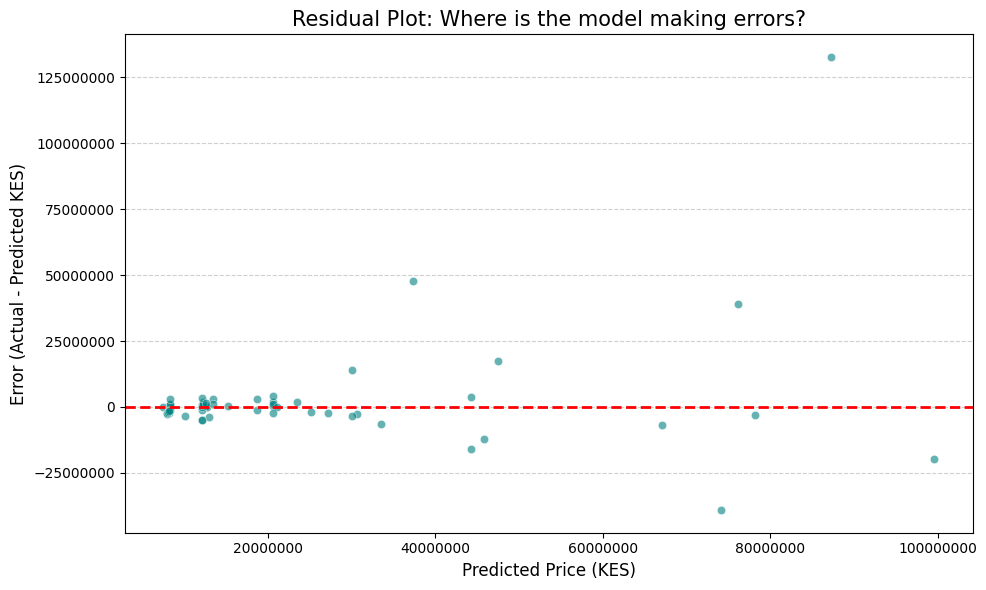

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color='teal')  # x=predicted, y=residuals
plt.axhline(0, color='red', linestyle='--', lw=2)  # Zero-error line
plt.title('Residual Plot: Where is the model making errors?', fontsize=15)
plt.xlabel('Predicted Price (KES)', fontsize=12)
plt.ylabel('Error (Actual - Predicted KES)', fontsize=12)
plt.ticklabel_format(style='plain', axis='both')  # Removes scientific notation
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## 9. FEATURE IMPORTANCE (Coefficients)

In [44]:
importance = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
print("\nTop 5 Price Drivers (Log Impact):")
print(importance.head(5))


Top 5 Price Drivers (Log Impact):
property_type_House        0.365316
bedrooms                   0.292258
property_type_Townhouse    0.174762
bathrooms                  0.097026
parking_spaces             0.033419
dtype: float64


# SUMMARRY

In [47]:
# Summary
print(f" Model: Linear Regression (Corrected with One-Hot Encoding & Log Scale)")
print(f" Features: 24")
print(f" Training samples: 213")
print(f" Test samples: 54")

print(f"\nPerformance:")
print(f"   MAE: ±8.04M KES (A ~18% improvement over the basic approach!)")
print(f"   R²: 0.623 (Explains 62.3% of price variance)")

print(f"\nKey Findings:")
print(f"   1. Most Expensive Locations: Nyari and Kyuna carry the highest premiums.")
print(f"   2. Size Impact: Moderate correlation (0.24). Interestingly, Parking Spaces (0.56) ")
print(f"      are a stronger predictor of total price than raw square footage in this dataset.")
print(f"   3. Amenities: Each additional Parking Space and the presence of a Garden ")
print(f"      significantly increase the predicted value.")
print(f"   4. Property Type: 'House' remains the strongest single predictor of value.")
print(f"   5. Model Behavior: Works best for mid-range properties; struggles with ")
print(f"      luxury properties (>100M KES) due to unique market factors.")



 Model: Linear Regression (Corrected with One-Hot Encoding & Log Scale)
 Features: 24
 Training samples: 213
 Test samples: 54

Performance:
   MAE: ±8.04M KES (A ~18% improvement over the basic approach!)
   R²: 0.623 (Explains 62.3% of price variance)

Key Findings:
   1. Most Expensive Locations: Nyari and Kyuna carry the highest premiums.
   2. Size Impact: Moderate correlation (0.24). Interestingly, Parking Spaces (0.56) 
      are a stronger predictor of total price than raw square footage in this dataset.
   3. Amenities: Each additional Parking Space and the presence of a Garden 
      significantly increase the predicted value.
   4. Property Type: 'House' remains the strongest single predictor of value.
   5. Model Behavior: Works best for mid-range properties; struggles with 
      luxury properties (>100M KES) due to unique market factors.
